In [1]:
!pip install piqa


In [2]:
#SSIM https://github.com/Po-Hsun-Su/pytorch-ssim
#import pytorch_ssim
from piq import ssim as ssim
#from piqa import SSIM 


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

import cv2
torch.set_printoptions(precision=10)

from IPython.display import display
from PIL import Image




In [3]:
#preprocess image
transform = transforms.Compose(
    [transforms.ToTensor()
     ])


#load image
true_image = cv2.imread("blueh.jpg",cv2.COLOR_BGR2RGB)
true_image = cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB)

samestyle = cv2.imread("blue0.jpg",cv2.COLOR_BGR2RGB)
samestyle = cv2.cvtColor(samestyle, cv2.COLOR_BGR2RGB)

samemask = cv2.imread("greenh.jpg",cv2.COLOR_BGR2RGB)
samemask = cv2.cvtColor(samemask, cv2.COLOR_BGR2RGB)

true_mask = cv2.imread("maskh.jpg")
samestyle_mask = cv2.imread("mask0.jpg")

#m3 = cv2.merge((m,m,m))

#Input Image
input_image = transform(true_image).unsqueeze(0)
ss_input_image = transform(samestyle).unsqueeze(0)
sm_input_image = transform(samemask).unsqueeze(0)

#Image for criterion - Style
gt_image = input_image.clone()
gt_ss_image = ss_input_image.clone()
gt_sm_image = sm_input_image.clone()

#Image for criterion - mask
gt_mask = transform(true_mask).unsqueeze(0)
gt_mask = gt_mask.mean(axis=1).unsqueeze(0)

gt_ss_mask = transform(samestyle_mask).unsqueeze(0)
gt_ss_mask = gt_ss_mask.mean(axis=1).unsqueeze(0)



In [43]:
# Display results

def display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13):
    print("Epoch = ", epoch)
    print("Total Loss = {:.3f}".format(total_loss.item()))
    print("Mask Loss = {:.3f}".format(loss_mask.item()))
    print("Style Loss = {:.3f}".format(loss_style.item()))
    print("12 Loss = {:.3f}".format(loss_12.item()))
    print("13 Loss = {:.3f}".format(loss_13.item()))
    print("Same Style Loss = {:.3f}".format(loss_samestyle.item()))
    print("Same mask Loss = {:.3f}".format(loss_samemask.item()))    
    return

def display_images(image,mask,recon,flag=0):
    
    image = torch.clamp(image, 0, 1)
    mask = torch.clamp(mask, 0, 1)
    if mask.shape[1] == 1:
        mask = mask.repeat(1,3,1,1)
    recon = torch.clamp(recon, 0, 1)
    
    if flag == 1:
        print("SSIM Score = {:.3f}".format( ssim(mask, recon).item()))
    else:
        print("SSIM Score = {:.3f}".format( ssim(image, recon).item()))
    
    image = transforms.ToPILImage()(image.squeeze())
    mask = transforms.ToPILImage()(mask.squeeze())
    recon = transforms.ToPILImage()(recon.squeeze())
    
    fig =plt.figure(figsize=(5,5))
    fig.add_subplot(1,3,1);plt.imshow(image)
    fig.add_subplot(1,3,2);plt.imshow(mask)
    fig.add_subplot(1,3,3);plt.imshow(recon)

    plt.show()    

    

def display_all(gt_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               ):
    print("Base Image (Image 1)")
    display_images(gt_image, out_mask, out_image)
    
    print("\nSame Style (Image 2)")
    display_images(gt_ss_image, ss_out_mask, ss_out_image)
    
    print("\nSame Mask (Image 3)")
    display_images(gt_sm_image, sm_out_mask, sm_out_image)
    
    print("\nFirst Image style + Second Image Mask --> Expected Image 2, (Same style different mask)")
    display_images(gt_image, gt_ss_image, out12_image, flag=1)
    
    print("\nThird Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)")
    display_images(gt_sm_image, gt_image, out13_image)
    
    return

In [5]:
input_image.min(), input_image.max(), input_image.shape

(tensor(0.), tensor(0.7921568751), torch.Size([1, 3, 64, 64]))

In [6]:
gt_image.min(), gt_image.max(), gt_mask.shape

(tensor(0.), tensor(0.7921568751), torch.Size([1, 1, 64, 64]))

In [7]:
samemask.shape

(64, 64, 3)

In [8]:
#true_mask_tensor.min(), true_mask_tensor.max()


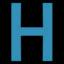

In [9]:
Image.fromarray(true_image)

In [10]:
class encoder(nn.Module):
        def __init__(self):
                super(encoder, self).__init__()
                self.conv1 = nn.Conv2d(3,64, kernel_size=3)
                self.conv2 = nn.Conv2d(64,32, kernel_size=3)
                self.conv3 = nn.Conv2d(32,16, kernel_size=3)
                
                self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
                self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)
                self.conv1d3 = nn.Conv1d(512,256, kernel_size=1)

                self.upconv1 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1)
                self.upconv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1)
                self.upconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1)
                
   
        def forward(self,x):
                #Encodings
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = F.relu(self.conv3(x))
                #print("X shape", x.shape) # torch.Size([1, 16, 58, 58])
                
                #Style vector
                x_style = torch.flatten(x,1)
                x_style = x_style.unsqueeze(-1)
                x_style = F.relu(self.conv1d1(x_style))
                x_style = F.relu(self.conv1d2(x_style))
                x_style = F.relu(self.conv1d3(x_style))
                #print("Final X_Style: ", x_style.shape)

                #Image 
                x_image = F.relu(self.upconv1(x))
                x_image = F.relu(self.upconv2(x_image))
                x_image = self.upconv3(x_image)
            
#                 x_style = inverse_normalization(x_style)
#                 x_image = inverse_normalization(x_image)
                
#                 x_image = inverse_normalization(x_image)
                
                return x_style, x_image





In [11]:
class decoder(nn.Module):
        def __init__(self):
              super(decoder, self).__init__()
                  
              #Convert style for concat
              self.conv1d0 = nn.Conv1d(256,512, kernel_size=1)

              #Convert image for concat
              self.conv1 = nn.Conv2d(1,64, kernel_size=3)
              self.conv2 = nn.Conv2d(64,32, kernel_size=3)
              self.conv3 = nn.Conv2d(32,16, kernel_size=3)
              self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
              self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)

              #Convert image
              self.conv1d3 = nn.Conv1d(1024, 1024, kernel_size=1)
              self.conv1d4 = nn.Conv1d(1024, 1024, kernel_size=1)

              #Using Upsample + Upconv
   
              self.upsample1 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv1 = nn.ConvTranspose2d(16, 16, 1, stride=1)
              self.upsample2 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv2 = nn.ConvTranspose2d(16, 16, 1, stride=1)              
              self.upsample3 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv3 = nn.ConvTranspose2d(16, 3, 1, stride=1)
       
              
                

        def forward(self,x_style,x_image):
              
#               x_image /= 255.0 
              #x_style = torch.from_numpy(x_style)
              #x_image = torch.from_numpy(x_image)
                
              x1 = F.relu(self.conv1d0(x_style)) # 512 style
            
              x2 = F.relu(self.conv1(x_image))
              x2 = F.relu(self.conv2(x2))
              x2 = F.relu(self.conv3(x2))
              x2 = torch.flatten(x2, 1)
              x2 = x2.unsqueeze(-1)
              x2 = F.relu(self.conv1d1(x2))
              x2 = F.relu(self.conv1d2(x2))     # 512 image

              x = torch.cat([x1,x2], dim=1) #Linear concatenate, output = [1,1024]

              x = F.relu(self.conv1d3(x))
              x = F.relu(self.conv1d4(x))
              x = (torch.reshape(x, (16,8,8))).unsqueeze(dim=0)

              x = self.upsample1(x)
              x = F.relu(self.upconv1(x))
              x = self.upsample2(x)
              x = F.relu(self.upconv2(x))
              x = self.upsample3(x)
              x = self.upconv3(x)

#               x = inverse_normalization(x)
            
              return x


In [12]:
class MyModel(nn.Module):
    def __init__(self, enc, dec):
      super(MyModel, self).__init__()
      self.enc = enc
      self.dec = dec

    def forward(self, x):
      style, output_mask = self.enc(x)
      output_img = self.dec(style, output_mask)
      return output_img, output_mask, style


In [13]:
enc = encoder()
dec = decoder()
model = MyModel(enc,dec)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
#for g in optimizer.param_groups:
#    g['lr'] = 1e-4


In [ ]:
# ss = samestyle, sm = samemask
# Image 1 = Base Image
# Image 2 = Same style, different character
# Image 3 = Different style, same character

for epoch in range(150):

    optimizer.zero_grad() 
    
    # Full pass
    out_image, out_mask, out_style = model(input_image)
    ss_out_image, ss_out_mask, ss_out_style = model(ss_input_image)
    sm_out_image, sm_out_mask, sm_out_style = model(sm_input_image)
    
    # Reconstruction/Style loss
    loss_out_style = criterion(out_image.squeeze(0), gt_image)
    loss_ss_out_style = criterion(ss_out_image.squeeze(0), gt_ss_image)    
    loss_sm_out_style = criterion(sm_out_image.squeeze(0), gt_sm_image)
    loss_style = loss_out_style + loss_ss_out_style + loss_sm_out_style
    
    # Mask Loss
    loss_out_mask = criterion(out_mask.squeeze(0), gt_mask)
    loss_ss_out_mask = criterion(ss_out_mask.squeeze(0), gt_ss_mask)    
    loss_sm_out_mask = criterion(sm_out_mask.squeeze(0), gt_mask) # Same mask
    loss_mask = loss_out_mask + loss_ss_out_mask + loss_sm_out_mask
    
    # First Image style (Blue) + Second Image Mask (Zero) --> Expected Image 2 i.e samestyle image
    out12_image = model.dec(out_style, ss_out_mask)
    loss_12 = criterion(out12_image.squeeze(0), gt_ss_image)
    
    # Third Image style (Green) + First Image Mask (H) --> Expected Image 3 i.e samemask image
    out13_image = model.dec(sm_out_style, out_mask)
    loss_13 = criterion(out13_image.squeeze(0), gt_sm_image)
    
    # Same style vector loss
    loss_samestyle = criterion(out_style, ss_out_style)
    
    # Same mask loss
    loss_samemask = criterion(out_mask, sm_out_mask)
    
    total_loss = loss_style + loss_mask + loss_12 + loss_13 + loss_samestyle + loss_samemask

    display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13)
    
    print("-----"*20)
    total_loss.backward()
    optimizer.step()



In [44]:
display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13)

Epoch =  149
Total Loss = 0.079
Mask Loss = 0.002
Style Loss = 0.046
12 Loss = 0.009
13 Loss = 0.022
Same Style Loss = 0.000
Same mask Loss = 0.000


Base Image (Image 1)
SSIM Score = 0.443


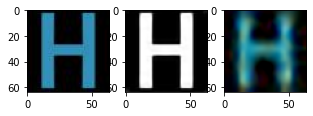


Same Style (Image 2)
SSIM Score = 0.521


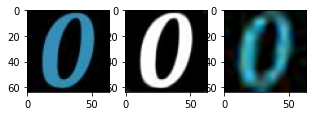


Same Mask (Image 3)
SSIM Score = 0.429


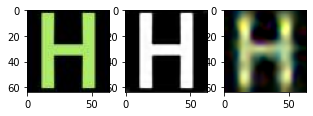


First Image style + Second Image Mask --> Expected Image 2, (Same style different mask)
SSIM Score = 0.521


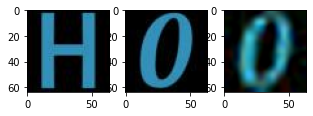


Third Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)
SSIM Score = 0.429


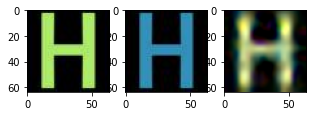

In [35]:
display_all(gt_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               )